In [9]:
# increase the usability of matplotlib in Jupyter Notebooks 
%matplotlib notebook             

from IG_scheduling import * # import module to perform interval graph scheduling similar to melon paper

In [17]:
## Settings for this run
n_arm  = 1 
n_cell = 1

v      = 0.15

one_arm = IG_scheduling(v, n_arm, n_cell)

In [18]:
one_arm.initDummyNodes()
one_arm.initBaseTimeIntervals()
print()
one_arm.chooseArm4Fruit()

In [19]:
one_arm.calcResults()

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 1
Number of arms in row: 1

Total harvested fruit: 15
FPE = fruit picked / total fruit:           0.07936507936507936
FPT = total fruit / total vehicle run time: 0.22499999999999998 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 15 


In [20]:
fruit_picked_by_one_arm = one_arm.fruitPickedBy()
# one_arm.calculateStateTimePercent(fruit_picked_by_one_arm)

[[[11, 24, 36, 47, 64, 77, 90, 96, 108, 123, 130, 146, 154, 164, 173], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]]]


In [21]:
## Multiple runs checking one arm results vs multiple arm results - FPT_N_arms / (N*FPT_onearm)
final_cells = 6  # total final number of rows being analyzed
final_arms  = 6  # total final number of arms per row being analyzed

FPT_results = np.zeros([final_cells, final_arms])
FPE_results = np.zeros([final_cells, final_arms])

FPT    = np.zeros([final_cells, final_arms])
FPE    = np.zeros([final_cells, final_arms])
t_arms = np.zeros([final_cells, final_arms])

for rows in range(1,final_cells+1):
    for arms in range(1,final_arms+1):
        total_arms = rows * arms
        
        multi_arm = IG_scheduling(v, arms, rows)
        multi_arm.initDummyNodes()
        multi_arm.initBaseTimeIntervals()
        multi_arm.chooseArm4Fruit()
        multi_arm.calcResults()
        
        FPT_analysis = multi_arm.FPT / (total_arms*one_arm.FPT)
        FPE_analysis = multi_arm.FPE / (total_arms*one_arm.FPE)
        
        print('one arm FPT:', one_arm.FPT, 'multi-arm FPT:', multi_arm.FPT)
        print('one arm FPE:', one_arm.FPE, 'multi-arm FPE:', multi_arm.FPE)
        
        print('----------------------------------------------------------')
        print()
        
        FPT[rows-1, arms-1]    = multi_arm.FPT 
        FPE[rows-1, arms-1]    = multi_arm.FPE
        t_arms[rows-1, arms-1] = total_arms
        
        FPT_results[rows-1, arms-1] = FPT_analysis 
        FPE_results[rows-1, arms-1] = FPE_analysis 
        


print()
print('----------------------------------------------------------')
print('----------------------------------------------------------')
print('FPT:', FPT_results)
print('FPE:', FPE_results)
print('total arms:', t_arms)

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 1
Number of arms in row: 1

Total harvested fruit: 15
FPE = fruit picked / total fruit:           0.07936507936507936
FPT = total fruit / total vehicle run time: 0.22499999999999998 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 15 
one arm FPT: 0.22499999999999998 multi-arm FPT: 0.22499999999999998
one arm FPE: 0.07936507936507936 multi-arm FPE: 0.07936507936507936
----------------------------------------------------------

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 1
Number of arms in row: 2

Total harvested fruit: 26
FPE = fruit picked / total fruit:           0.13756613756613756
FPT = total fruit / total vehicle run time: 0.38999999999999996 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 15  arm 1: 11 
one arm FPT: 0.22499999999999998 multi-arm FPT: 0.38999999999999996
one arm FPE: 0.07936507936507936 

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 3
Number of arms in row: 4

Total harvested fruit: 110
FPE = fruit picked / total fruit:           0.582010582010582
FPT = total fruit / total vehicle run time: 1.65 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 15  arm 1: 11  arm 2: 8  arm 3: 6 
Number of fruit picked by row/pool 1  arm 0: 13  arm 1: 10  arm 2: 6  arm 3: 5 
Number of fruit picked by row/pool 2  arm 0: 15  arm 1: 11  arm 2: 7  arm 3: 3 
one arm FPT: 0.22499999999999998 multi-arm FPT: 1.65
one arm FPE: 0.07936507936507936 multi-arm FPE: 0.582010582010582
----------------------------------------------------------

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 3
Number of arms in row: 5

Total harvested fruit: 118
FPE = fruit picked / total fruit:           0.6243386243386243
FPT = total fruit / total vehicle run time: 1.7699999999999998 fruit/sec

Numb

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 5
Number of arms in row: 3

Total harvested fruit: 143
FPE = fruit picked / total fruit:           0.7566137566137566
FPT = total fruit / total vehicle run time: 2.145 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 14  arm 1: 10  arm 2: 6 
Number of fruit picked by row/pool 1  arm 0: 14  arm 1: 10  arm 2: 7 
Number of fruit picked by row/pool 2  arm 0: 11  arm 1: 10  arm 2: 6 
Number of fruit picked by row/pool 3  arm 0: 13  arm 1: 9  arm 2: 5 
Number of fruit picked by row/pool 4  arm 0: 14  arm 1: 10  arm 2: 4 
one arm FPT: 0.22499999999999998 multi-arm FPT: 2.145
one arm FPE: 0.07936507936507936 multi-arm FPE: 0.7566137566137566
----------------------------------------------------------

Total number of fruit: 189
Total time: 66.66666666666667 sec
Vehicle velocity: 0.15 m/s
Number of rows: 5
Number of arms in row: 4

Total harvested fruit: 156
FPE = fruit picked / total f

 [ 6. 12. 18. 24. 30. 36.]]


<IPython.core.display.Javascript object>


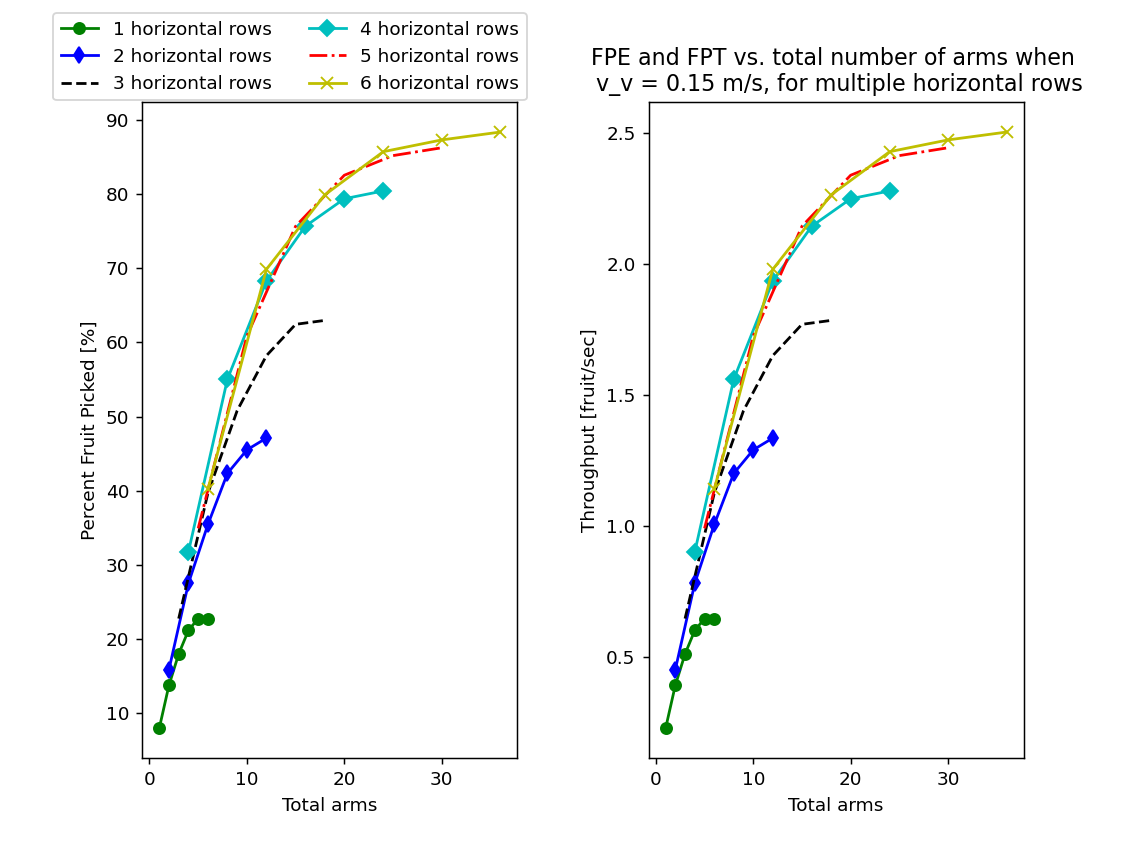

In [22]:
'''Analyze the results FPE and FPT vs number of arms'''
fig, ax = plt.subplots(ncols=2) #, figsize=(20, 22))

xLabel = 'total arms'

# change y-label depending on variable tested
if xLabel == 'v_v':
    label = "Vehicle Velocity [m/sec]"
elif xLabel == 'v_a':
    label = "Arm Max Velocity [m/sec]"
elif xLabel == 'arm':
    label = "No. of Arms per Row"
elif xLabel == 'total arms':
    label = "Total arms"
    
color = ['o-g', 'd-b', '--k', 'D-c', '-.r', 'x-y']

for n in range(final_cells):
    label_val = str(n+1) + ' horizontal rows'
    
    ax[0].plot(t_arms[n], FPE[n]*100, color[n], label=label_val)
    ax[1].plot(t_arms[n], FPT[n], color[n], label=label_val)

ax[0].set_xlabel(label)
ax[0].set_ylabel("Percent Fruit Picked [%]")

ax[1].set_xlabel(label)
ax[1].set_ylabel("Throughput [fruit/sec]")

plt.subplots_adjust(wspace=0.35)

# ax[0].legend(bbox_to_anchor=(1, 1.1) ,loc='upper right', ncol=1)
ax[1].legend(bbox_to_anchor=(-.3, 1.15),loc='upper right', ncol=2)

title_tot_arms = 'FPE and FPT vs. total number of arms when \n v_v = '+str(one_arm.v) + ' m/s, for multiple horizontal rows'

plt.title(title_tot_arms)

# plt.savefig("monte_mean.png",dpi=300)
plt.show()

In [1]:
'''Analyze the results comparing one arm versus multiple arms in each row'''
fig = plt.figure()
ax = plt.axes(projection ='3d')

num_points = max(final_cells, final_arms)

x_axis = np.linspace(1, final_cells, num_points, endpoint=True)
y_axis = np.linspace(1, final_arms, num_points, endpoint=True)

for n in range(final_cells):
    FPT_label = 'FPT for ' + str(n+1) + ' rows'
#     FPE_label = 'FPE for ' + str(n+1) + ' rows'
#     print(FPT_results[n])
    
    plt.plot(x_axis, 
             y_axis,
             FPT_results[n], 'o--', label=FPT_label)
    
#     plt.plot(x_axis, 
#              y_axis,
#              FPE_results[n], 'x-', label=FPE_label)


legend = ax.legend(loc='upper right')

plt.xticks(x_axis)
plt.yticks(y_axis)
                   
ax.set_xlabel('Number of rows [n]')
ax.set_ylabel('Number of arms in row [k]')
ax.set_zlabel('FPT_{k = N*K} / ( N*K * FPT_{k=1})')

plt.show()

NameError: name 'plt' is not defined

In [1]:
# increase the usability of matplotlib in Jupyter Notebooks 
%matplotlib notebook             

from IG_scheduling import * # import module to perform interval graph scheduling similar to melon paper

test_arms = 5
test_rows = 4
test_v    = 0.13

multi_arm = IG_scheduling(test_v, test_arms, test_rows)
multi_arm.initDummyNodes()
multi_arm.initBaseTimeIntervals()
multi_arm.chooseArm4Fruit()
multi_arm.calcResults()
print()
fruit_picked_by_4rows_5arms = multi_arm.fruitPickedBy()

Total number of fruit: 280
Total time: 76.92307692307692 sec
Vehicle velocity: 0.13 m/s
Number of rows: 4
Number of arms in row: 5

Total harvested fruit: 264
FPE = fruit picked / total fruit:           0.9428571428571428
FPT = total fruit / total vehicle run time: 3.432 fruit/sec

Number of fruit picked by row/pool 0  arm 0: 14  arm 1: 14  arm 2: 13  arm 3: 13  arm 4: 12 
Number of fruit picked by row/pool 1  arm 0: 14  arm 1: 14  arm 2: 13  arm 3: 13  arm 4: 12 
Number of fruit picked by row/pool 2  arm 0: 14  arm 1: 14  arm 2: 13  arm 3: 13  arm 4: 12 
Number of fruit picked by row/pool 3  arm 0: 14  arm 1: 14  arm 2: 13  arm 3: 13  arm 4: 12 

[[[0, 31, 54, 70, 91, 114, 131, 155, 172, 190, 210, 230, 254, 272], [13, 32, 55, 72, 92, 115, 132, 156, 173, 195, 212, 235, 255, 273], [33, 56, 73, 93, 116, 133, 157, 174, 196, 213, 236, 256, 274], [34, 57, 74, 94, 117, 134, 158, 175, 197, 214, 237, 257, 275], [58, 75, 99, 118, 139, 159, 179, 198, 219, 238, 258, 276], [14, 15, 16, 35]], [[11,

<IPython.core.display.Javascript object>


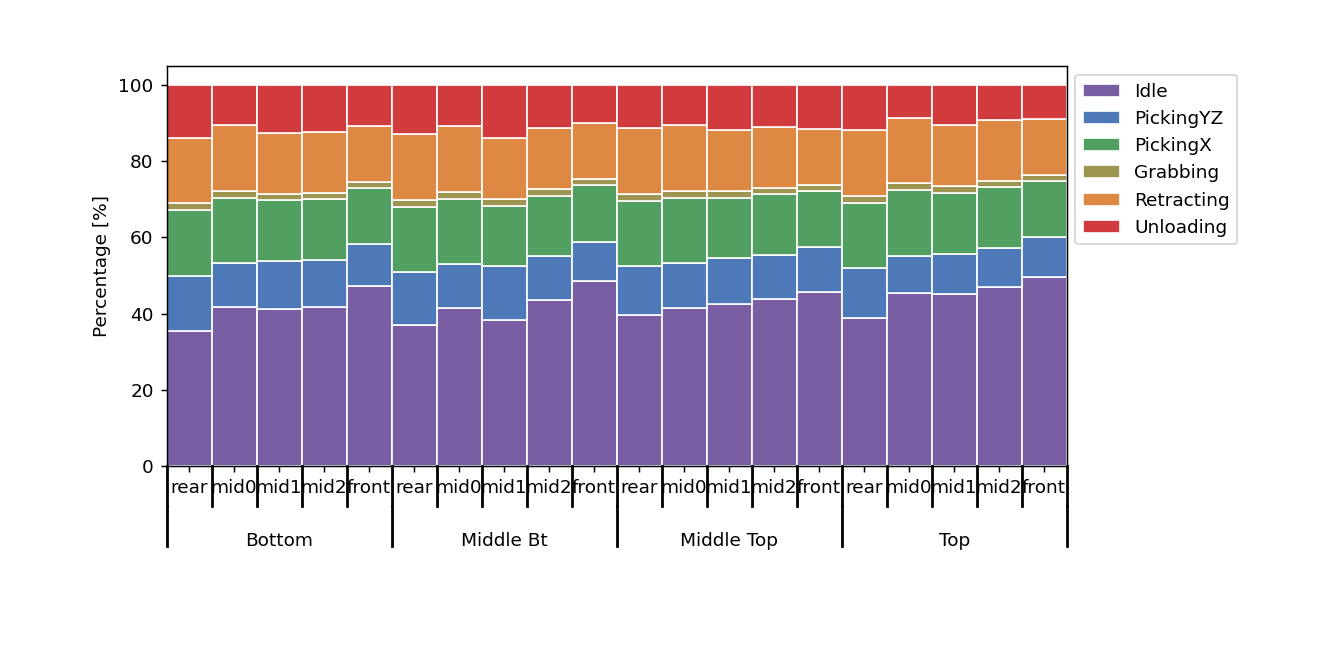

In [2]:
multi_arm.calculateStateTimePercent(fruit_picked_by_4rows_5arms)

<IPython.core.display.Javascript object>


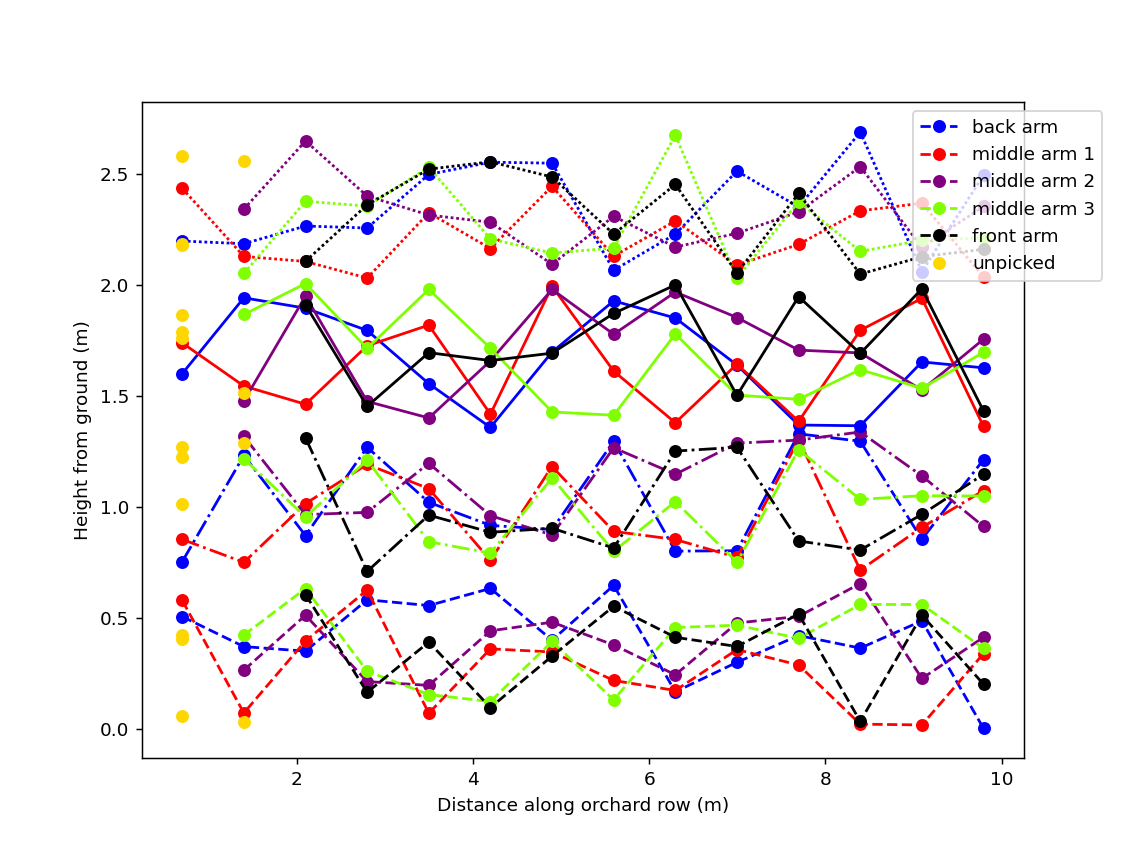

In [3]:
multi_arm.plot2DSchedule(fruit_picked_by_4rows_5arms)

In [ ]:
# '''Plot the intervals -- Testing time not distance intervals'''
# # based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# # plot is based on time...
# fig, ax = plt.subplots()

# for e in IG.edges():
#     if e[1].k == 0:
#         intervalGraph(e[1].k, e[2], e[3], color='c')
#     elif e[1].k == 1:
#         intervalGraph(e[1].k, e[2], e[3], color='r')
#     elif e[1].k == 2:
#         intervalGraph(e[1].k, e[2], e[3], color='b')

# plt.xlabel('Time (sec)')
# plt.ylabel('Arm number')
        
# plt.show()